Using cpu device
Model accuracy: 12.80%


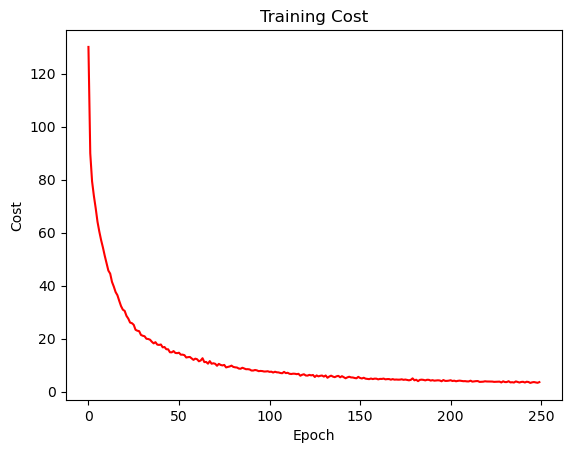

In [4]:
import os
import torch
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Read data, convert to PyTorch tensors
data = pd.read_csv("lidar.csv", header=None)
X = data.iloc[:, 0:16].values
y = data.iloc[:, 16].values

trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# use Cuda Y/N 
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using {device} device")

#Neural Network construction
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, outputs),
            
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(16, 1).to(device)

# Training
epochs = 250  
batch_size = 4
learning_rate = 0.001

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataloader = DataLoader(
    dataset=torch.utils.data.TensorDataset(trainingSetX, trainingSetY),
    batch_size=batch_size,
    shuffle=True
)

losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_function(yhat, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(epoch_loss / len(dataloader))

# Evaluate
model.eval()
y_pred = model(trainingSetX.to(device))
acc = (y_pred.round() == trainingSetY.to(device)).float().mean()
acc = float(acc)
print("Model accuracy: %.2f%%" % (acc*100))

# Saving Model
with open('SDCar_Lidar.pth', 'wb') as f:
    torch.save(model.linear_relu_stack, f)

# Compare
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")
plt.plot([x for x in range(epochs)], losses, 'red')
plt.show()